In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.registration import phase_cross_correlation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.set_soft_device_placement(False)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
tf.config.list_logical_devices()

2021-12-06 00:40:54.762997: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 00:40:56.692469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
tf.config.get_soft_device_placement(), gpus[0]

(False, PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'))

In [5]:
gpus[0].name

'/physical_device:GPU:0'

In [6]:
!pwd

/gpfs/fs1/home/skandel/code/mbptycho/mbptycho/tests/partial_edge_sparse_scan/apodized_probe_weak_peaks


In [7]:
strain_type = 'two_edge_slip'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'


In [8]:
!ls $sim_data_path

/home/skandel/code/mbptycho/experiments/python/two_edge_slip_sparse/apodized_probe_weak_peaks/sim_two_edge_slip.pkl


In [9]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.params.sample_pix_size

File exists. Reloading...


0.005844363636363636

## Directly reconstructing the displacements

In [10]:
recons = DisplacementFullModelReconstruction(simulation=sm, 
                                             shared_magnitudes=True, 
                                             unwrap_phase_proj=True, 
                                             batch_size=50)

Setting background_level to 1e-08...


In [17]:
disp_lr = 2e-2
magnitude_lr = 2e-2
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.02>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x150d349c5f10>,
  'var': <tf.Variable 'ux_uy:0' shape=(16530,) dtype=float32, numpy=
  array([ 4.5515504,  4.3751836,  4.6834645, ..., -2.6380239, -2.6455812,
         -2.6448312], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.02>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x150d349c5dc0>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(8268,) dtype=float32, numpy=
  array([-14.347814  , -12.777795  , -11.733144  , ...,  -0.12883566,
          -0.59784687,  -1.3949854 ], dtype=float32)>}}

In [18]:
recons.minimize(1000, debug_output_epoch_frequency=10)

          epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
5562        928    5.69e+04      0.884      0.809        0.772        0.683      0.621      0.674      0.683      0.659          0.616          0.673          0.681          0.654
5622        938   7.45e+04      0.884       0.77       0.78      0.695      0.611      0.586       0.68      0.707      0.608      0.582      0.677      0.704
5682        948   3.73e+04      0.875      0.778      0.825      0.667      0.539      0.499      0.599      0.606      0.533      0.492      0.594      0.602
5742        958   1.82e+04      0.911      0.858      0.868      0.766      0.568      0.591      0.552      0.528      0.563      0.588      0.543      0.521
5802        968   6.41e+04      0.878      0.821      0.764      0.779      0.585      0.622      0.553      0.516      0.577       0.62      0.544      0.509
5862

KeyboardInterrupt: 

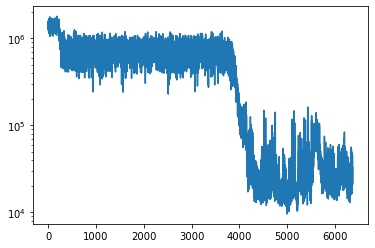

In [19]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [20]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = phase_cross_correlation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

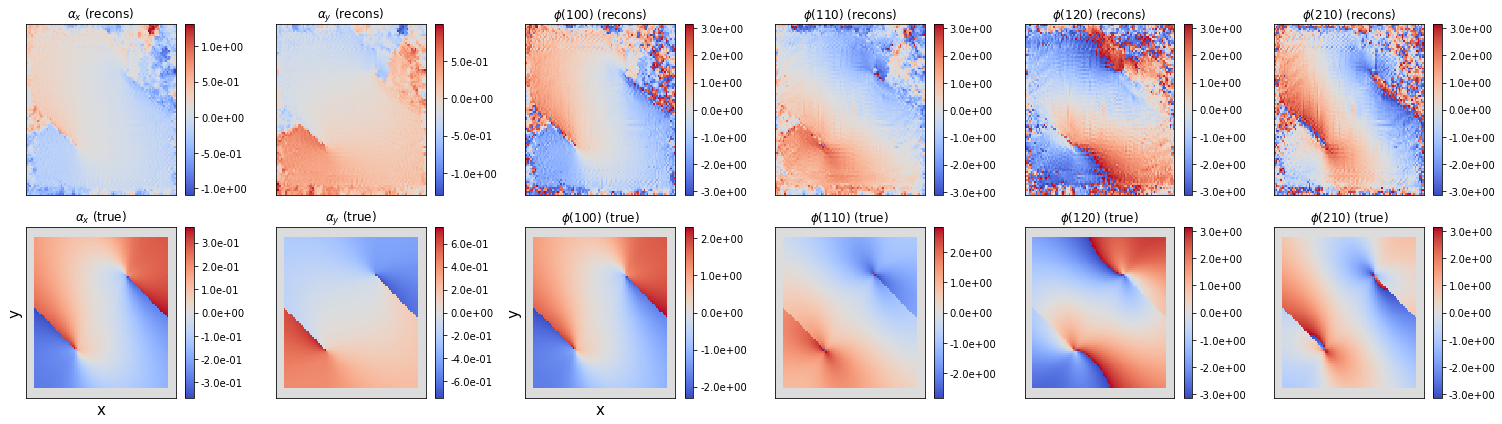

In [21]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

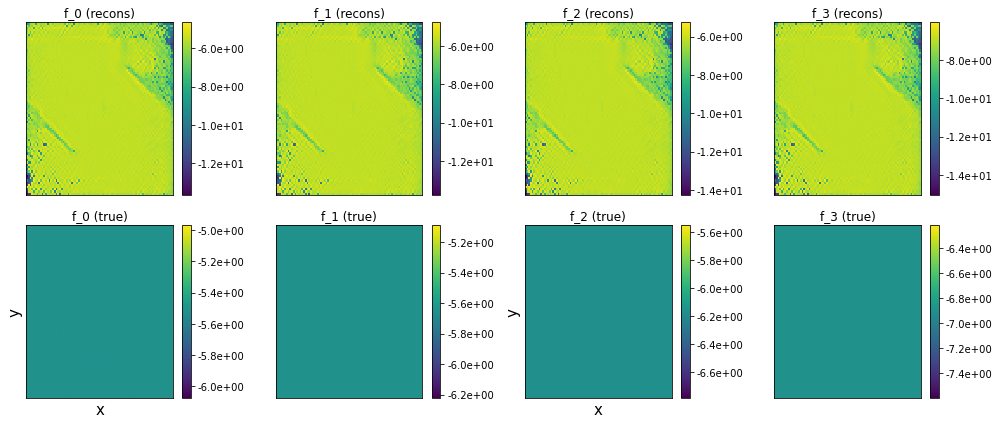

In [22]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][5:-5,5:-5])
    true_amplitudes = np.abs(recons._rho_true[i][5:-5,5:-5])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [31]:
recons.saveOutputsAndLog(data_path, prefix='direct_projected_')

In [32]:
!ls $data_path

direct_projected_df_displacement_to_data_shared_mags.gz
direct_projected_rho_displacement_to_data_shared_mags.npz
direct_projected_ux_displacement_to_data_shared_mags.npz
direct_projected_uy_displacement_to_data_shared_mags.npz
sample_two_edge_slip.pkl
sim_two_edge_slip.pkl


In [33]:
import pandas as pd

In [34]:
dload = pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')

In [45]:
dload.dropna()

,epoch,train_loss,err_ux,err_uy,err_ux_film,err_uy_film,err_rho0,err_rho1,err_rho2,err_rho3,err_rho_film0,err_rho_film1,err_rho_film2,err_rho_film3
6,1.0,1.327504e+06,0.943592,0.945883,0.860780,0.930600,0.856190,0.814066,0.950989,0.794378,0.826826,0.781750,0.951921,0.748797
12,2.0,1.574635e+06,0.945099,0.933951,0.865130,0.927963,0.835899,0.775196,0.901426,0.781327,0.803609,0.740844,0.903574,0.726738
18,3.0,1.508859e+06,0.940401,0.924064,0.862458,0.908877,0.827748,0.749029,0.854202,0.786261,0.797791,0.714017,0.847445,0.737490
24,4.0,1.292722e+06,0.932479,0.896009,0.871023,0.884350,0.833905,0.717980,0.838194,0.783563,0.804110,0.668180,0.811867,0.734244
30,5.0,1.344622e+06,0.929973,0.933845,0.914289,0.903939,0.841808,0.703573,0.815803,0.797479,0.810391,0.631683,0.780093,0.742606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3288,548.0,1.825432e+04,0.883207,0.731905,0.869809,0.662437,0.454894,0.416822,0.474373,0.493575,0.442622,0.402989,0.462904,0.482947
3294,549.0,1.896971e+04,0.916089,0.786550,0.919690,0.757268,0.465217,0.430801,0.477822,0.496891,0.453805,0.418134,0.466688,0.486678
3300,550.0,1.928014e+04,0.846847,0.701573,0.757236,0.580717,0.454501,0.415390,0.469742,0.493179,0.442464,0.401626,0.457961,0.482688
3306,551.0,1.249915e+04,0.857371,0.707583,0.775459,0.538372,0.452120,0.411595,0.468240,0.493440,0.440095,0.397800,0.456283,0.482925


In [36]:
ux = recons_items[r'$\alpha_x$']
uy = recons_items[r'$\alpha_y$']

In [37]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [38]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [39]:

import matplotlib.colors as colors

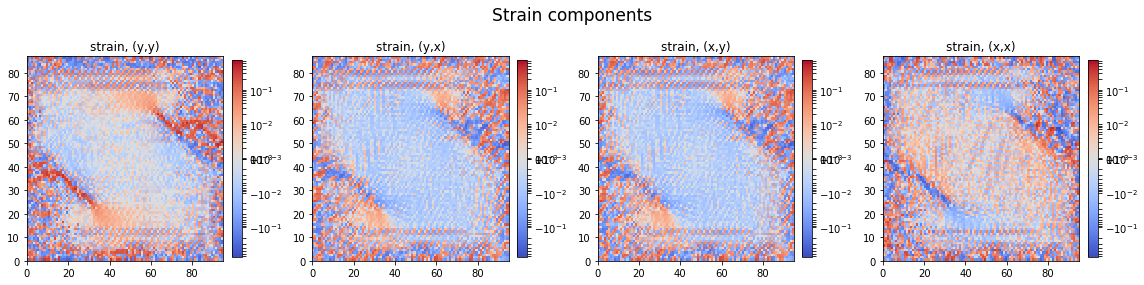

In [40]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [41]:
s.max(), s.min()

(0.5760899782180786, -0.7999232411384583)

In [42]:
ux = true_items[r'$\alpha_x$']
uy = true_items[r'$\alpha_y$']

In [43]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

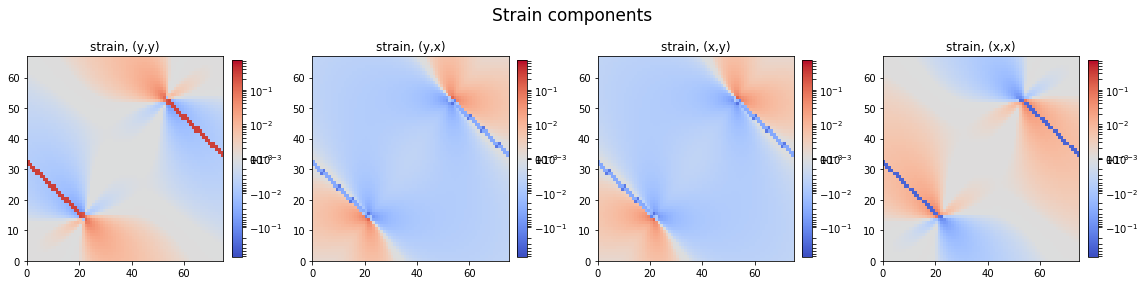

In [44]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-0.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [102]:
sl.max()

0.14155861493467398

In [106]:
s.max(), s.min()

(0.512089098698885, -0.2560819462227913)